source https://www.youtube.com/watch?v=QIUxPv5PJOY&t=9s

### This notebook uses a Long Short Term Memory (LSTM) neural network to predict the adjusted closing stock price using the previous 60 days stock price

In [1]:
# Import the dependencies

import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
plt.style.use('seaborn')

df = pd.read_csv("../../Resources/stocks_joined.csv")
df

,company_id,company,date_ipo,market_capitalization,pet_market_segment,company_size,Date,Adj_Close,Volume,Ticker
0,1,"Chewy, Inc,",2019-06-14,13.95B,"Pet Supplies, E-commerce",21300,2019-10-16 00:00:00,26.490000,1374800,CHWY
1,1,"Chewy, Inc,",2019-06-14,13.95B,"Pet Supplies, E-commerce",21300,2019-10-17 00:00:00,26.740000,1716500,CHWY
2,1,"Chewy, Inc,",2019-06-14,13.95B,"Pet Supplies, E-commerce",21300,2019-10-18 00:00:00,27.049999,1704100,CHWY
3,1,"Chewy, Inc,",2019-06-14,13.95B,"Pet Supplies, E-commerce",21300,2019-10-21 00:00:00,27.860001,1548700,CHWY
4,1,"Chewy, Inc,",2019-06-14,13.95B,"Pet Supplies, E-commerce",21300,2019-10-22 00:00:00,28.059999,1371900,CHWY
...,...,...,...,...,...,...,...,...,...,...
2015,6,"Freshpet, Inc.",2014-11-01,2.582B,Pet Food,789,2021-10-11 00:00:00,130.360001,285700,FRPT
2016,6,"Freshpet, Inc.",2014-11-01,2.582B,Pet Food,789,2021-10-12 00:00:00,132.190002,383600,FRPT
2017,6,"Freshpet, Inc.",2014-11-01,2.582B,Pet Food,789,2021-10-13 00:00:00,141.240005,298000,FRPT
2018,6,"Freshpet, Inc.",2014-11-01,2.582B,Pet Food,789,2021-10-14 00:00:00,147.080002,272600,FRPT


In [2]:
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.rename(columns = {'Adj Close':'Adj_Close'}, inplace=True)
df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2020 entries, 2019-10-16 to 2021-10-15
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   company_id             2020 non-null   int64  
 1   company                2020 non-null   object 
 2   date_ipo               2020 non-null   object 
 3   market_capitalization  2020 non-null   object 
 4   pet_market_segment     2020 non-null   object 
 5   company_size           2020 non-null   int64  
 6   Adj_Close              2020 non-null   float64
 7   Volume                 2020 non-null   int64  
 8   Ticker                 2020 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 157.8+ KB


Ticker
CHWY    AxesSubplot(0.125,0.2;0.775x0.68)
ELAN    AxesSubplot(0.125,0.2;0.775x0.68)
FRPT    AxesSubplot(0.125,0.2;0.775x0.68)
PETQ    AxesSubplot(0.125,0.2;0.775x0.68)
Name: Adj_Close, dtype: object

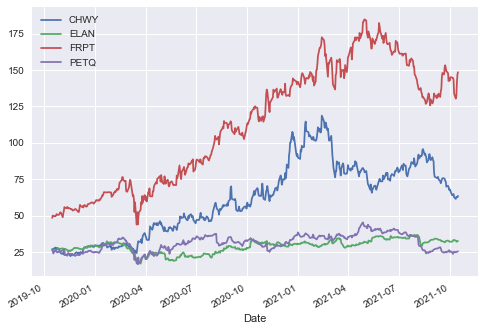

In [3]:
df.groupby('Ticker')['Adj_Close'].plot(legend=True)

In [4]:
options = ['PETQ','ELAN']
df2 = df[df["Ticker"].isin(options)]

Ticker
ELAN    AxesSubplot(0.125,0.2;0.775x0.68)
PETQ    AxesSubplot(0.125,0.2;0.775x0.68)
Name: Adj_Close, dtype: object

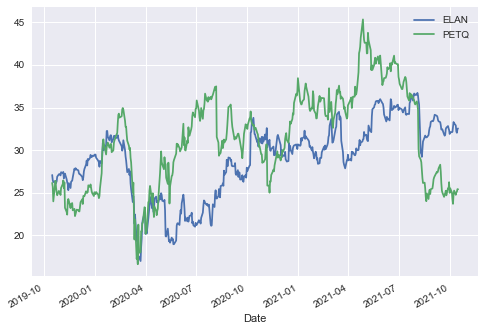

In [5]:
df2.groupby('Ticker')['Adj_Close'].plot(legend=True)

In [6]:
chwy_df = df[df.Ticker == 'CHWY']

In [7]:
chwy_df.shape

(505, 9)

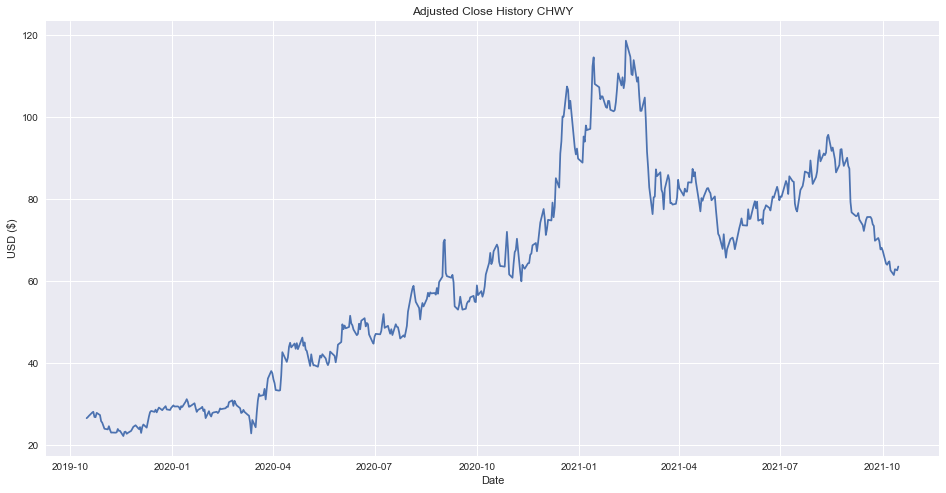

In [8]:
plt.figure(figsize=(16,8))
plt.title('Adjusted Close History CHWY')
plt.plot(chwy_df.Adj_Close)
plt.xlabel('Date')
plt.ylabel('USD ($)')
plt.show()

In [9]:
# separate the target (Adj_Close) into a new df
data = chwy_df.filter(['Adj_Close'])

# convert df to a numpy array
chwy_data = data.values

# get the number of rows to train the model on using 80% of the data
training_data_len = math.ceil(len(chwy_data) * .8)
training_data_len

404

In [10]:
# scale the data between 0 and 1 inclusive
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(chwy_data)
scaled_data

array([[0.04515328],
       [0.04774235],
       [0.05095277],
       [0.05934136],
       [0.06141259],
       [0.04826017],
       [0.04763878],
       [0.05861642],
       [0.05302404],
       [0.03769678],
       [0.03376139],
       [0.0263049 ],
       [0.01843414],
       [0.01677714],
       [0.02485503],
       [0.01563794],
       [0.00869925],
       [0.00890639],
       [0.00849215],
       [0.00932065],
       [0.01781277],
       [0.01315245],
       [0.01315245],
       [0.        ],
       [0.01025271],
       [0.01108121],
       [0.00569595],
       [0.00787075],
       [0.01304888],
       [0.01833058],
       [0.02330157],
       [0.02723696],
       [0.01760564],
       [0.02257664],
       [0.00787075],
       [0.02278377],
       [0.02920466],
       [0.02123033],
       [0.03490059],
       [0.04919221],
       [0.06027342],
       [0.06348385],
       [0.06110192],
       [0.06669429],
       [0.05985916],
       [0.06659072],
       [0.07197598],
       [0.065

In [11]:
# create the training set
train_data = scaled_data[0:training_data_len, :]

# split the data into x_train and y_train sets
x_train = []
y_train = []

for i in range (60, len(train_data)):
    # gets 60 values from 0 to 59
    x_train.append(train_data[i-60:i, 0])
    # gets the 61st value
    y_train.append(train_data[i, 0])
    if i<= 60:
        print(x_train) # contains the past 60 values
        print(y_train) # contains the next value which we want to predict

[array([0.04515328, 0.04774235, 0.05095277, 0.05934136, 0.06141259,
       0.04826017, 0.04763878, 0.05861642, 0.05302404, 0.03769678,
       0.03376139, 0.0263049 , 0.01843414, 0.01677714, 0.02485503,
       0.01563794, 0.00869925, 0.00890639, 0.00849215, 0.00932065,
       0.01781277, 0.01315245, 0.01315245, 0.        , 0.01025271,
       0.01108121, 0.00569595, 0.00787075, 0.01304888, 0.01833058,
       0.02330157, 0.02723696, 0.01760564, 0.02257664, 0.00787075,
       0.02278377, 0.02920466, 0.02123033, 0.03490059, 0.04919221,
       0.06027342, 0.06348385, 0.06110192, 0.06669429, 0.05985916,
       0.06659072, 0.07197598, 0.06534799, 0.06917978, 0.07549711,
       0.06731566, 0.06586579, 0.07114748, 0.07756837, 0.07466861,
       0.07497931, 0.07321874, 0.06721211, 0.07560067, 0.07352942])]
[0.086888988601212]


In [12]:
# convert the training sets to numpy arrays for the LSTM model
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape  # has 2 dimensions

(344, 60)

In [13]:
# reshape the x_train data to meet the LSTM model requirements for #samples, #timesteps and #features (3 dimensions)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(344, 60, 1)

In [14]:
# build the LSTM model
model = keras.Sequential()

# add layer with 50 neurons, and first layer needs input_shape equal to # of timesteps
model.add(layers.LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(50, return_sequences=False)) # no more LSTM layers to follow
model.add(layers.Dense(25)) 
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [15]:
# compile the model
model.compile(optimizer='adam', loss= 'mean_squared_error') # loss measures how well the model trained

# train the model
model.fit(x_train, y_train, batch_size=1, epochs=5)

Epoch 1/5
344/344 [==============================] - 9s 15ms/step - loss: 0.0066
Epoch 2/5
344/344 [==============================] - 5s 15ms/step - loss: 0.0039
Epoch 3/5
344/344 [==============================] - 5s 15ms/step - loss: 0.0027
Epoch 4/5
344/344 [==============================] - 5s 15ms/step - loss: 0.0025
Epoch 5/5
344/344 [==============================] - 5s 15ms/step - loss: 0.0018


In [16]:
# create the testing data sets
# create a new array containing scaled values using the remaining 20%
test_data = scaled_data[training_data_len - 60: , : ]

x_test = []
y_test = chwy_data[training_data_len:] # actual adj_close values, not scaled

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [17]:
# convert to np array
x_test = np.array(x_test)

In [18]:
# reshape from a 2D to 3D array for the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [19]:
# get the model's adj_close predictions
predictions = model.predict(x_test)

# inverse transform the predictions to restore the scaled values to compare with actual prices
predictions = scaler.inverse_transform(predictions)

4/4 [==============================] - 1s 12ms/step


In [20]:
# get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse  # rsme closer to 0 shows better accuracy

2.157109323495997

C:\Users\laura\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


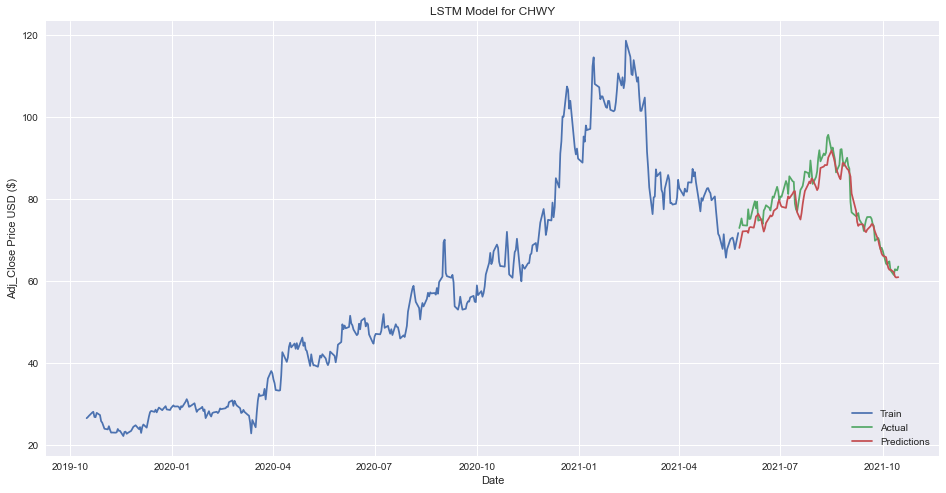

In [21]:
# plot
data = chwy_df.filter(['Adj_Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('LSTM Model for CHWY')
plt.xlabel('Date')
plt.ylabel('Adj_Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Adj_Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.show()

In [22]:
# show the actual and predicted prices
validation

,Adj_Close,Predictions
Date,,
2021-05-25,72.930000,68.081779
2021-05-26,73.959999,69.347061
2021-05-27,75.279999,70.733940
2021-05-28,73.620003,72.117500
2021-06-01,73.529999,72.187370
...,...,...
2021-10-11,61.459999,62.138798
2021-10-12,62.869999,61.085873
2021-10-13,62.730000,60.855698


In [23]:
# show the historical data
data

,Adj_Close
Date,
2019-10-16,26.490000
2019-10-17,26.740000
2019-10-18,27.049999
2019-10-21,27.860001
2019-10-22,28.059999
...,...
2021-10-11,61.459999
2021-10-12,62.869999
2021-10-13,62.730000
